In [57]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2018-12-31'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2020-12-31'


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

EIIE_MODEL = "trained_eiie/policy_EIIE_2018-12-31_4_2024-11-23 21_51_18.pt"

GRAPH_TITLE = "EIIE Trained 2009-2021, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3024, 8)


# Portfolio Optimization Algorithm

In [58]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34737474 0.85636632 0.54964338 0.51373051 0.38475346 0.42295937
 0.33556728 0.25343556 0.30422921 0.26926356 0.28669621 0.27967644
 0.31653185 0.28504842 0.21692903 0.23860167 0.3145108  0.24564113
 0.39002321 0.57311482 0.38207404 0.30637593 0.29537877 0.33857682
 0.2648435  0.29768774 0.22339453 0.19688542 0.20898455 0.21092307
 0.20478488 0.23096106 0.17793534 0.24491243 0.16177534 0.17737638
 0.20513845 0.16009191 0.26105273 0.26461654 0.24277227 0.25730886
 0.18510609 0.19516916 0.23255164 0.22507702 0.30021336 0.30449556
 0.29103655 0.22113901 0.36616164 0.24590092 0.29679398 0.29106187
 0.47862137 0.39771822 0.41120068 0.46705118 0.27993154 0.19488781
 0.22099365 0.2613022  0.21350683 0.21825326 0.17926239 0.17375067
 0.24273006 0.33545005 0.203

In [59]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_22624\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [60]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1781735.375
Final accumulative portfolio value: 1.781735375
Maximum DrawDown: -0.3721915237044281
Sharpe ratio: 0.8480959730132726
Total commission cost: 9354.452630052925


In [61]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2019-03-14
1      1.010537e+06 2019-03-15
2      1.014756e+06 2019-03-18
3      1.013869e+06 2019-03-19
4      1.011915e+06 2019-03-20
..              ...        ...
450    1.804040e+06 2020-12-23
451    1.784321e+06 2020-12-24
452    1.776894e+06 2020-12-28
453    1.778974e+06 2020-12-29
454    1.781735e+06 2020-12-30

[455 rows x 2 columns]


In [62]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2019-03-14 00:00:00
2020-12-30 00:00:00


In [63]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_benchmarks = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [64]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1485922.0
Final accumulative portfolio value: 1.485922
Maximum DrawDown: -0.3561142148874148
Sharpe ratio: 0.8485538265225109
Total commission cost: 5976.90916538029
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013119e+06 2019-03-18
3         1.012544e+06 2019-03-19
4         1.011011e+06 2019-03-20
..                 ...        ...
450       1.455001e+06 2020-12-23
451       1.463050e+06 2020-12-24
452       1.480505e+06 2020-12-28
453       1.489116e+06 2020-12-29
454       1.485922e+06 2020-12-30

[455 rows x 2 columns]


In [65]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1572628.125
Final accumulative portfolio value: 1.572628125
Maximum DrawDown: -0.30393298606590813
Sharpe ratio: 0.9789658867177495
Total commission cost: 5976.90916538029
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013094e+06 2019-03-18
3         1.012513e+06 2019-03-19
4         1.010968e+06 2019-03-20
..                 ...        ...
450       1.539773e+06 2020-12-23
451       1.550750e+06 2020-12-24
452       1.578312e+06 2020-12-28
453       1.578293e+06 2020-12-29
454       1.572628e+06 2020-12-30

[455 rows x 2 columns]


In [66]:


# BAH on each individual stock

BAH_results = {
    "test": {},
}

# Weights are in alphabetical order

# AAPL
model_kwargs_AAPL={
    "target_weights": np.array([0,1,0,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_AAPL)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_AAPL = pd.DataFrame(BAH_results["test"]["value"], columns=['AAPL_net_worth'])
df_bah_date_AAPL = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_AAPL['Date'] = df_bah_date['Date']


# "BA"
model_kwargs_BA={
    "target_weights": np.array([0,0,1,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_BA)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_BA = pd.DataFrame(BAH_results["test"]["value"], columns=['BA_net_worth'])
df_bah_date_BA = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_BA['Date'] = df_bah_date['Date']

# "INTC"
model_kwargs_INTC={
    "target_weights": np.array([0,0,0,1,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_INTC)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_INTC = pd.DataFrame(BAH_results["test"]["value"], columns=['INTC_net_worth'])
df_bah_date_INTC = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_INTC['Date'] = df_bah_date['Date']

# "MSFT"
model_kwargs_MSFT={
    "target_weights": np.array([0,0,0,0,1,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_MSFT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_MSFT = pd.DataFrame(BAH_results["test"]["value"], columns=['MSFT_net_worth'])
df_bah_date_MSFT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_MSFT['Date'] = df_bah_date['Date']

# "V"

model_kwargs_V={
    "target_weights": np.array([0,0,0,0,0,1,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_V)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_V = pd.DataFrame(BAH_results["test"]["value"], columns=['V_net_worth'])
df_bah_date_V = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_V['Date'] = df_bah_date['Date']

# WMT
model_kwargs_WMT={
    "target_weights": np.array([0,0,0,0,0,0,1])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_WMT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_WMT = pd.DataFrame(BAH_results["test"]["value"], columns=['WMT_net_worth'])
df_bah_date_WMT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_WMT['Date'] = df_bah_date['Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2967757.5
Final accumulative portfolio value: 2.9677575
Maximum DrawDown: -0.3142727464075503
Sharpe ratio: 1.7711975216662053
Total commission cost: 5976.90916538029
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 594338.375
Final accumulative portfolio value: 0.594338375
Maximum DrawDown: -0.7542346763765299
Sharpe ratio: -0.08735144542375019
Total commission cost: 5976.90916538029
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 952208.0
Final accumulative portfolio value: 0.952208
Maximum DrawDown: -0.3452654557381233
Sharpe ratio: 0.15680796318271054
Total commission cost: 5976.90916538029
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1975513.25
Final accumulative portfolio value: 1.97551325
Maximum DrawDown: -0.28039281350831113
Sharpe ratio: 1.2530982101027766
Total commission cost: 5976.90916538029
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1431443.0
Final accumulative portfolio value: 1.431443
Maximum DrawDown: -0.36364922308132386
Sharpe ratio: 0.755822077934653
Total commission cost: 5976.90916538029
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1514509.75
Final accumulative portfolio value: 1.51450975
Maximum DrawDown: -0.14206837770712089
Sharpe ratio: 1.0330335316101114
Total commission cost: 5976.90916538029
hit end!


# Stock environment optimization algorithm

In [67]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (454, 8)
Annual return          0.096183
Cumulative returns     0.179920
Annual volatility      0.285733
Sharpe ratio           0.466041
Calmar ratio           0.259349
Stability              0.058086
Max drawdown          -0.370862
Omega ratio            1.108194
Sortino ratio          0.638874
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.829211
Daily value at risk   -0.035471
dtype: float64
df_dji:            date           dji
0   2019-03-14  1.000000e+06
1   2019-03-15  1.005404e+06
2   2019-03-18  1.007941e+06
3   2019-03-19  1.006902e+06
4   2019-03-20  1.001390e+06
..         ...           ...
450 2020-12-23  1.171914e+06
451 2020-12-24  1.174638e+06
452 2020-12-28  1.182577e+06
453 2020-12-29  1.179920e+06
454 2020-12-30           NaN

[455 rows x 2 columns]
df_dji:                       dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06

# Compare all results

In [68]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt


# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge all stocks
df_bah_opt_AAPL['Date'] = pd.to_datetime(df_bah_opt_AAPL['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_AAPL, on='Date')

df_bah_opt_MSFT['Date'] = pd.to_datetime(df_bah_opt_MSFT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_MSFT, on='Date')

df_bah_opt_V['Date'] = pd.to_datetime(df_bah_opt_V['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_V, on='Date')

df_bah_opt_WMT['Date'] = pd.to_datetime(df_bah_opt_WMT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_WMT, on='Date')

df_bah_opt_BA['Date'] = pd.to_datetime(df_bah_opt_BA['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_BA, on='Date')

df_bah_opt_INTC['Date'] = pd.to_datetime(df_bah_opt_INTC['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_INTC, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06
2019-03-20  1.001390e+06
...                  ...
2020-12-23  1.171914e+06
2020-12-24  1.174638e+06
2020-12-28  1.182577e+06
2020-12-29  1.179920e+06
2020-12-30           NaN

[455 rows x 1 columns]
     crp_opt_net_worth       Date  bah_opt_net_worth  AAPL_net_worth  \
0         1.000000e+06 2019-03-14       1.000000e+06    1.000000e+06   
1         1.011105e+06 2019-03-15       1.011105e+06    1.013008e+06   
2         1.013119e+06 2019-03-18       1.013094e+06    1.023350e+06   
3         1.012544e+06 2019-03-19       1.012513e+06    1.015240e+06   
4         1.011011e+06 2019-03-20       1.010968e+06    1.024112e+06   
..                 ...        ...                ...             ...   
450       1.455001e+06 2020-12-23       1.539773e+06    2.906502e+06   
451       1.463050e+06 2020-12-24       1.550750e+06    2.928918e+06   
452

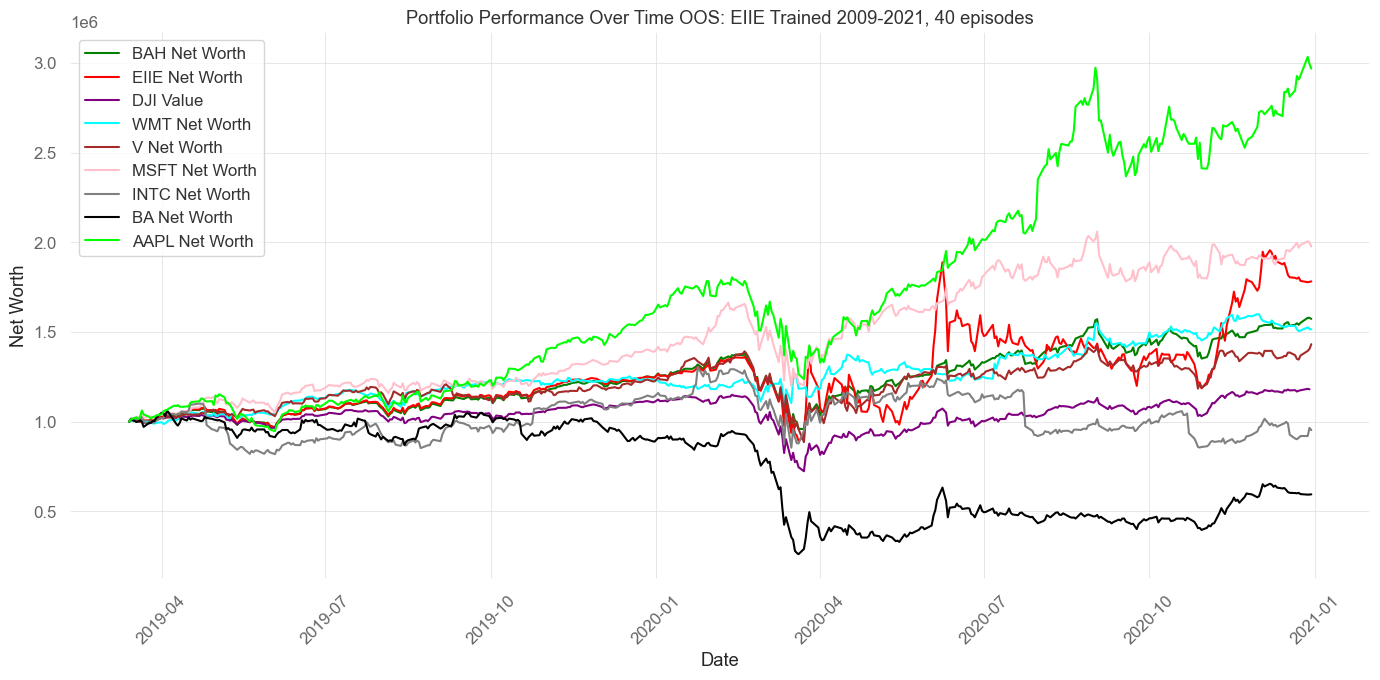

In [69]:
import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'WMT Net Worth': 'cyan',
    'V Net Worth': 'brown',
    'MSFT Net Worth': 'pink',
    'INTC Net Worth': 'gray',
    'BA Net Worth': 'black',
    'AAPL Net Worth': 'lime'
}

# Plot 1: OOS Portfolio Performance
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.plot(merged_df['Date'], merged_df['WMT_net_worth'], label='WMT Net Worth', color=color_map['WMT Net Worth'])
plt.plot(merged_df['Date'], merged_df['V_net_worth'], label='V Net Worth', color=color_map['V Net Worth'])
plt.plot(merged_df['Date'], merged_df['MSFT_net_worth'], label='MSFT Net Worth', color=color_map['MSFT Net Worth'])
plt.plot(merged_df['Date'], merged_df['INTC_net_worth'], label='INTC Net Worth', color=color_map['INTC Net Worth'])
plt.plot(merged_df['Date'], merged_df['BA_net_worth'], label='BA Net Worth', color=color_map['BA Net Worth'])
plt.plot(merged_df['Date'], merged_df['AAPL_net_worth'], label='AAPL Net Worth', color=color_map['AAPL Net Worth'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [70]:
import pprint

final_returns = {
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'WMT': merged_df['WMT_net_worth'].iloc[-1],
    'V': merged_df['V_net_worth'].iloc[-1],
    'MSFT': merged_df['MSFT_net_worth'].iloc[-1],
    'AAPL': merged_df['AAPL_net_worth'].iloc[-1],
    'BA': merged_df['BA_net_worth'].iloc[-1],
    'INTC': merged_df['INTC_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'AAPL': 2967757.5,
 'BA': 594338.375,
 'BAH': 1572628.125,
 'CRP': 1485922.0,
 'EIIE': 1781735.375,
 'INTC': 952208.0,
 'MSFT': 1975513.25,
 'V': 1431443.0,
 'WMT': 1514509.75}


In [71]:
import numpy as np
import pprint


# Calculate daily returns for each specified portfolio
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['WMT_opt_daily_return'] = merged_df['WMT_net_worth'].pct_change()
merged_df['V_opt_daily_return'] = merged_df['V_net_worth'].pct_change()
merged_df['MSFT_opt_daily_return'] = merged_df['MSFT_net_worth'].pct_change()
merged_df['AAPL_opt_daily_return'] = merged_df['AAPL_net_worth'].pct_change()
merged_df['BA_opt_daily_return'] = merged_df['BA_net_worth'].pct_change()
merged_df['INTC_opt_daily_return'] = merged_df['INTC_net_worth'].pct_change()

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate the Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'].dropna(), risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'].dropna(), risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'].dropna(), risk_free_rate),
    'WMT': calculate_sharpe_ratio(merged_df['WMT_opt_daily_return'].dropna(), risk_free_rate),
    'V': calculate_sharpe_ratio(merged_df['V_opt_daily_return'].dropna(), risk_free_rate),
    'MSFT': calculate_sharpe_ratio(merged_df['MSFT_opt_daily_return'].dropna(), risk_free_rate),
    'AAPL': calculate_sharpe_ratio(merged_df['AAPL_opt_daily_return'].dropna(), risk_free_rate),
    'BA': calculate_sharpe_ratio(merged_df['BA_opt_daily_return'].dropna(), risk_free_rate),
    'INTC': calculate_sharpe_ratio(merged_df['INTC_opt_daily_return'].dropna(), risk_free_rate),

}


pprint.pprint(sharpe_ratios)

{'AAPL': 1.7208172542489477,
 'BA': -0.11696515707907816,
 'BAH': 0.9142381717557435,
 'CRP': 0.7868716616023621,
 'EIIE': 0.8130015923183951,
 'INTC': 0.11097895098440151,
 'MSFT': 1.1974142200231292,
 'V': 0.697633813861053,
 'WMT': 0.9552685052665705}


In [72]:
import numpy as np
import pandas as pd


# Define a function to calculate the max drawdown
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

# Calculate max drawdowns for each portfolio
max_drawdowns = {
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'WMT': max_drawdown(merged_df['WMT_net_worth']),
    'V': max_drawdown(merged_df['V_net_worth']),
    'MSFT': max_drawdown(merged_df['MSFT_net_worth']),
    'AAPL': max_drawdown(merged_df['AAPL_net_worth']),
    'BA': max_drawdown(merged_df['BA_net_worth']),
    'INTC': max_drawdown(merged_df['INTC_net_worth']),
}

pprint.pprint(max_drawdowns)


{'AAPL': -0.3142727464075503,
 'BA': -0.7542346763765299,
 'BAH': -0.30393298606590813,
 'CRP': -0.3561142148874148,
 'EIIE': -0.3721915237044281,
 'INTC': -0.3452654557381233,
 'MSFT': -0.28039281350831113,
 'V': -0.36364922308132386,
 'WMT': -0.14206837770712089}


In [73]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000108    1.0  0.135331  0.713054
Residual   0.719980  906.0       NaN       NaN


In [74]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.011105
2      0.001967
3     -0.000573
4     -0.001525
5      0.014001
         ...   
450   -0.005379
451    0.007129
452    0.017773
453   -0.000012
454   -0.003589
Name: BAH_opt_daily_return, Length: 454, dtype: float64
t-statistic: 0.3678729695296477
p-value: 0.7130538810574928
